In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.model_selection import KFold
from pylab import rcParams
#from sklearn.preprocessing import StandardScaler
import os
os.chdir('/home/roman/Documents/Projects/Cost_Sensitive')

In [2]:
# Prepare data (y_train and y_test)
data = pd.read_csv('data/creditcard.csv')
y = data.iloc[:, -1]
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=123, shuffle=True)
kf.get_n_splits(y)
y_train_l, y_test_l = [], []
for train_index, test_index in kf.split(y):
    y_train_l.append(y.iloc[train_index])
    y_test_l.append(y.iloc[test_index])
# load results:
y_pred_train_lr = np.load('results/y_pred_train_lr.npy')
y_pred_test_lr = np.load('results/y_pred_test_lr.npy')
y_pred_train_lr_probas = np.load('results/y_pred_train_lr_probas.npy')
y_pred_test_lr_probas = np.load('results/y_pred_test_lr_probas.npy')
y_pred_train_ann = np.load('results/y_pred_train_ann.npy')
y_pred_test_ann = np.load('results/y_pred_test_ann.npy')
y_pred_train_ann_probas = np.load('results/y_pred_train_ann_probas.npy')
y_pred_test_ann_probas = np.load('results/y_pred_test_ann_probas.npy')
y_pred_train_ann_cs = np.load('results/y_pred_train_ann_cs.npy')
y_pred_test_ann_cs = np.load('results/y_pred_test_ann_cs.npy')
y_pred_train_ann_cs_probas = np.load('results/y_pred_train_ann_cs_probas.npy')
y_pred_test_ann_cs_probas = np.load('results/y_pred_test_ann_cs_probas.npy')

In [3]:
# ROC curves
def stack_y_probas(y_proba):
    y_proba = np.hstack((y_proba, 1 - y_proba))
    return np.array([y_proba[:int(y_proba.shape[0]/2)], y_proba[int(y_proba.shape[0]/2):]]).T
y_test_2D = []
for y_test in y_test_l:
    y_test = LabelBinarizer().fit_transform(y_test)
    y_test = np.hstack((y_test, 1 - y_test))
    y_test_2D.append(y_test)
y_pred_test_lr_probas_2D, y_pred_test_ann_probas_2D, y_pred_test_ann_cs_probas_2D = [], [], []
for i in range(n_splits):
    y_pred_test_lr_probas_2D.append(stack_y_probas(y_pred_test_lr_probas[i]))
    y_pred_test_ann_probas_2D.append(stack_y_probas(y_pred_test_ann_probas[i]))
    y_pred_test_ann_cs_probas_2D.append(stack_y_probas(y_pred_test_ann_cs_probas[i].reshape(-1)))

In [4]:
def create_roc_auc(y_true, y_pred):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

In [7]:
fpr_lr, tpr_lr, roc_auc_lr, tprs_lr = [], [], [], []
mean_fpr = np.linspace(0, 1, 100)
for y_true, y_pred in zip(y_test_2D, y_pred_test_lr_probas_2D):
    fpr, tpr, roc_auc = create_roc_auc(y_true, y_pred)
    tprs_lr.append(interp(mean_fpr, fpr[1], tpr[1]))
    tprs_lr[-1][0] = 0.0
    fpr_lr.append(fpr)
    tpr_lr.append(tpr)
    roc_auc_lr.append(roc_auc)
mean_tpr_lr = np.mean(tprs_lr, axis=0)
mean_tpr_lr[-1] = 1.0
mean_auc_lr = auc(mean_fpr, mean_tpr_lr)
 
fpr_ann, tpr_ann, roc_auc_ann, tprs_ann = [], [], [], []
for y_true, y_pred in zip(y_test_2D, y_pred_test_ann_probas_2D):
    fpr, tpr, roc_auc = create_roc_auc(y_true, y_pred)
    tprs_ann.append(interp(mean_fpr, fpr[1], tpr[1]))
    tprs_ann[-1][0] = 0.0
    fpr_ann.append(fpr)
    tpr_ann.append(tpr)
    roc_auc_ann.append(roc_auc)
mean_tpr_ann = np.mean(tprs_ann, axis=0)
mean_tpr_ann[-1] = 1.0
mean_auc_ann = auc(mean_fpr, mean_tpr_ann)

fpr_ann_cs, tpr_ann_cs, roc_auc_ann_cs, tprs_ann_cs = [], [], [], []
for y_true, y_pred in zip(y_test_2D, y_pred_test_ann_cs_probas_2D):
    fpr, tpr, roc_auc = create_roc_auc(y_true, y_pred)
    tprs_ann_cs.append(interp(mean_fpr, fpr[1], tpr[1]))
    tprs_ann_cs[-1][0] = 0.0
    fpr_ann_cs.append(fpr)
    tpr_ann_cs.append(tpr)
    roc_auc_ann_cs.append(roc_auc)
mean_tpr_ann_cs = np.mean(tprs_ann_cs, axis=0)
mean_tpr_ann_cs[-1] = 1.0
mean_auc_ann_cs = auc(mean_fpr, mean_tpr_ann_cs)

0.9655652178248615

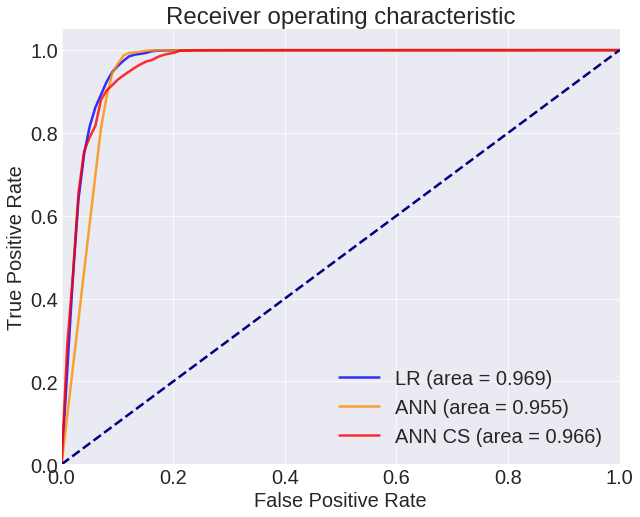

In [23]:
#plt.figure()
lw = 2.5
alpha = 0.8

plt.rcParams.update({'font.size': 20, 'figure.figsize': [10,8]})
plt.style.use('seaborn-darkgrid')
plt.plot(mean_fpr, mean_tpr_lr, color='blue', lw=lw, alpha=alpha, \
         label='LR (area = %0.3f)' % mean_auc_lr)
plt.plot(mean_fpr, mean_tpr_ann, color='darkorange', lw=lw, alpha=alpha, \
         label='ANN (area = %0.3f)' % mean_auc_ann)
plt.plot(mean_fpr, mean_tpr_ann_cs, color='red', lw=lw, alpha=alpha, \
         label='ANN CS (area = %0.3f)' % mean_auc_ann_cs)
        
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
tpr_ann

In [ ]:
len(fpr_ann)

In [ ]:
np.linspace(0, 1, 100)

In [ ]:
fpr_ann

In [ ]:
#np.interp([1,2,3,4,5],[3,3.5,2,2.5,1],2.33,'linear')
interp(2.33,[1,2,3,4,5],[3,3.5,2,2,1])